## CriticalPath analysis

__UNDER CONSTRUCTION__

This notebook provides an example of a simulation that takes a number of __sub_processes__, grouped in a __SequentialActivity__, that is executed in a __WhileActivity__ while a __stop condition__ is not yet met.

For this example we work with the following __sub_processes__:
* sailing empty
* loading
* sailing full
* unloading

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 100,
                  "level": 100
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 100,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 0.0004,
                 "unloading_rate": 0.0004,
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3 Create activity/activities

In [6]:
# initialise registry
registry = {}

In [7]:
# create a list of the sub processes
sub_processes = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=4,
        duration=1000,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=to_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=4,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="basic activity",
        registry=registry,
        duration=0,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
        env=my_env,
        name="sequential",
        registry=registry,
        sub_processes=sub_processes,
    )

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

#### 4. Register processes and run simpy

In [8]:
# initate the simpy processes defined in the 'while activity' and run simpy
model.register_processes([while_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [9]:
plot.get_log_dataframe(vessel01, [while_activity])

,Activity,Timestamp,ActivityState,geometry,container level,type,ref
0,sailing empty,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
1,sailing empty,1970-01-01 00:00:00.000000,STOP,POINT (4.18055556 52.18664444),0.0,NaN,NaN
2,loading,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
3,loading,1970-01-01 00:16:40.000000,STOP,POINT (4.18055556 52.18664444),4.0,NaN,NaN
4,sailing full,1970-01-01 00:16:40.000000,START,POINT (4.18055556 52.18664444),4.0,NaN,NaN
...,...,...,...,...,...,...,...
245,sailing full,1970-01-02 02:26:38.404972,STOP,POINT (4.25222222 52.11428333),4.0,NaN,NaN
246,unloading,1970-01-02 02:26:38.404972,START,POINT (4.25222222 52.11428333),4.0,NaN,NaN
247,unloading,1970-01-02 02:43:18.404972,STOP,POINT (4.25222222 52.11428333),0.0,NaN,NaN
248,basic activity,1970-01-02 02:43:18.404972,START,POINT (4.25222222 52.11428333),0.0,additional log,4d231fda-2f7c-414c-a191-253401739a77


##### 5.2 Visualise gantt charts

In [10]:
plot.get_gantt_chart([while_activity])

In [11]:
plot.get_gantt_chart([vessel01, from_site, to_site],id_map=[while_activity])

##### 5.3 Visualise container volume developments

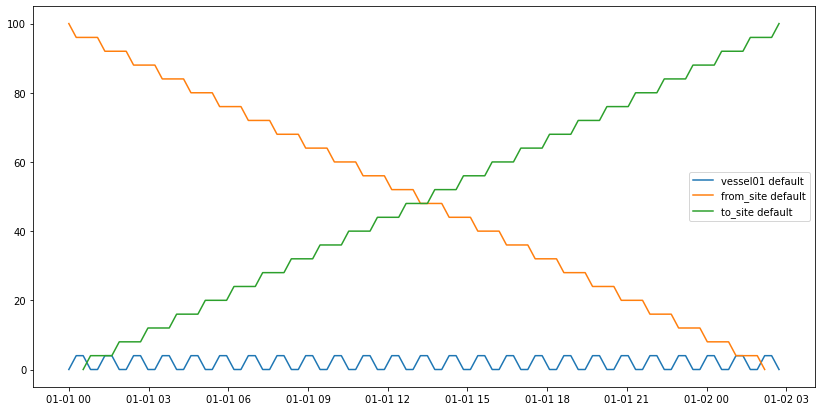

In [12]:
fig = plot.get_step_chart([vessel01, from_site, to_site])

#### Sandbox

In [13]:
pd.DataFrame.from_dict(vessel01.log)

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel
0,1970-01-01 00:00:00.000000,565c6049-6285-42b2-8931-c6b511b80767,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
1,1970-01-01 00:00:00.000000,565c6049-6285-42b2-8931-c6b511b80767,STOP,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
2,1970-01-01 00:00:00.000000,0b081282-e3e6-4f87-97d4-4bc8dda434d0,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
3,1970-01-01 00:16:40.000000,0b081282-e3e6-4f87-97d4-4bc8dda434d0,STOP,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
4,1970-01-01 00:16:40.000000,b0229e1b-c794-4470-af0d-534a59ee77a0,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
...,...,...,...,...,...
245,1970-01-02 02:26:38.404972,b0229e1b-c794-4470-af0d-534a59ee77a0,STOP,"{'geometry': POINT (4.25222222 52.11428333), '...",{}
246,1970-01-02 02:26:38.404972,1727a573-aaa2-4cfd-be0d-0ec783a0d9fc,START,"{'geometry': POINT (4.25222222 52.11428333), '...",{}
247,1970-01-02 02:43:18.404972,1727a573-aaa2-4cfd-be0d-0ec783a0d9fc,STOP,"{'geometry': POINT (4.25222222 52.11428333), '...",{}
248,1970-01-02 02:43:18.404972,4d231fda-2f7c-414c-a191-253401739a77,START,"{'geometry': POINT (4.25222222 52.11428333), '...","{'type': 'additional log', 'ref': '4d231fda-2f..."


In [14]:
list(set(vessel01.log["ActivityID"]))

['565c6049-6285-42b2-8931-c6b511b80767',
 '4d231fda-2f7c-414c-a191-253401739a77',
 '1727a573-aaa2-4cfd-be0d-0ec783a0d9fc',
 '0b081282-e3e6-4f87-97d4-4bc8dda434d0',
 'b0229e1b-c794-4470-af0d-534a59ee77a0']